In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Bipropellant-Propulsion-System-Model/julia`


In [54]:
# Numerics
using DifferentialEquations, ModelingToolkit
# Display
using Plots

using CoolProp

In [8]:
@parameters t
D = Differential(t)

(::Differential) (generic function with 3 methods)

In [60]:
R̄ = 8.314 # J/mol/K
N2_p(T, D) = PropsSI("P", "T", T, "D", D, "Nitrogen")
@register_symbolic N2_p(T, D)
# Flow connectors connect by making the sum zero
# Equality connectors connect by making the values equal #! This is the default behavior
# Stream connectors are for fluids
# https://discourse.julialang.org/t/modelingtoolkit-variable-metadata-for-connectors/92056/3
@connector FluidPort begin
    p(t) = 0.0
    T(t) = 0.0, [connect = Stream]
    ṁ(t) = 0.0, [connect = Flow]
end

@mtkmodel FluidElement begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end
    @variables begin
        dp(t) = 0.0 # Pa
        ṁ(t) = 0.0 # kg/s
    end
    @equations begin
        dp ~ port_a.p - port_b.p
        port_a.ṁ ~ ṁ
        port_a.ṁ + port_b.ṁ ~ 0
    end
end


@mtkmodel GasVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
        p_init = 1e5 # Pa
        T = 300.0 # K
        V = 1.0 # m^3
        molar_mass = 14e-3 # kg/mol
    end

    @variables begin
        m(t) = m_init
        p(t) = p_init
    end

    @equations begin
        # Mass balance
        D(m) ~ port_a.ṁ + port_b.ṁ
        # p * V ~ m / molar_mass * R̄ * T
        p ~ N2_p(T, m / V)

        # Connect to ports
        port_a.p ~ p
        port_a.T ~ T

        port_b.p ~ p
        port_b.T ~ T
    end
end

@mtkmodel LiquidVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
    end

    @variables begin
        m(t) = m_init
        p(t)
    end

    @equations begin
        D(m) ~ port_a.ṁ + port_b.ṁ

        port_a.p ~ p
        port_b.p ~ p
    end
end

@mtkmodel PressureInterface begin
    @extend ṁ, dp = element1d = FluidElement()
    @equations begin
        ṁ ~ 0
        dp ~ 0
    end
end

# TwoPhaseTank with a gas and liquid phase
# Pressure determined by the gas phase
@component function TwoPhaseVolume(; name, mass_L=1.0, mass_G=0.5, p_init=1e5)
    @named gas = GasVolume(m_init=mass_G, p_init=p_init)
    @named liquid = LiquidVolume(m_init=mass_L)
    @named interface = PressureInterface()

    sys = [
        gas,
        liquid,
        interface,
    ]
    eqs = [
        connect(gas.port_a, interface.port_a),
        connect(liquid.port_a, interface.port_b),
    ]
    ODESystem(eqs, t, [], []; name=name, systems=sys)
end

@mtkmodel FluidResistor begin
    @extend ṁ, dp = element1d = FluidElement()
    @parameters begin
        R = 1e-6 # 1 kg/s/MPa
    end
    @equations begin
        ṁ ~ dp * R
    end
end

@mtkmodel ThreeWayValve begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
        port_c = FluidPort()
    end
    @equations begin
        port_a.p ~ port_b.p
        port_a.p ~ port_c.p
        port_a.ṁ + port_b.ṁ + port_c.ṁ ~ 0
    end
end

@mtkmodel ConstPressure begin
    @components begin
        port = FluidPort()
    end
    @parameters begin
        p = 1e5 # Pa
    end
    @equations begin
        port.p ~ p
    end
end

@mtkmodel Nozzle begin
    @components begin
        port_a = FluidPort()
    end

    @parameters begin
        D_throat = 0.01
        γ = 1.3
        Tc = 2500.0
        R = 296.0 #! ihatethisihatethisihatethisihatethis
        A_throat = π * D_throat^2 / 4
        p_init = 1e5
    end

    @variables begin
        p(t) = p_init
    end

    @equations begin
        port_a.ṁ ~ p * A_throat / sqrt(Tc) * sqrt(γ / R) * ((γ + 1) / 2)^(-(γ + 1) / (2 * (γ - 1)))
        port_a.p ~ p
    end
end

@mtkmodel SpiInjector begin
    @extend ṁ, dp = element1d = FluidElement()
    @parameters begin
        Cd = 0.8
        A = 1e-4
        ρ = 1e3
    end

    @equations begin
        ṁ ~ Cd * A * (2ρ * dp) / sqrt(2ρ * dp)
    end
end

@mtkmodel Pipe begin
    @extend ṁ, dp = element1d = FluidElement()

    @parameters begin
        D = 1e-2
        ρ = 1e3
        μ = 1e-3
    end

    @equations begin
        U ~ ṁ / (ρ * D^2 * π / 4.0)
        Re_D ~ ρ * U * D / μ
        f ~ 0.25 / (log10(k / (3.7 * D) + 5.74 / (Re_D^0.9))^2)
        dp ~ ṁ * abs(ṁ) * 8 * f * L / (ρ * π^2 * D^5)
    end
end


ModelingToolkit.Model{typeof(__Pipe__), Dict{Symbol, Any}}(__Pipe__, Dict{Symbol, Any}(:kwargs => Dict{Symbol, Any}(:ρ => 1000.0, :μ => 0.001, :D => 0.01), :independent_variable => t, :extend => Any[[:ṁ, :dp], :element1d, :FluidElement], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:ρ => Dict(:default => 1000.0), :μ => Dict(:default => 0.001), :D => Dict(:default => 0.01)), :equations => ["U ~ ṁ / ((ρ * D^2 * π) / 4.0)", "Re_D ~ (ρ * U * D) / μ", "f ~ 0.25 / log10(k / (3.7D) + 5.74 / Re_D^0.9)^2", "dp ~ (ṁ * abs(ṁ) * 8 * f * L) / (ρ * π^2 * D^5)"]), false)

In [62]:
@named N2_tank = GasVolume(p_init=70e5, m_init=10.0)
@named N2_orifice = FluidResistor(R=1e-6)
@named N2_valve = ThreeWayValve()

@named N2O_inlet = FluidResistor(R=1e-6)
@named N2O_tank = TwoPhaseVolume(mass_L=1.0, mass_G=0.5, p_init=1e5)
@named N2O_orifice = FluidResistor(R=1e-6)

@named MeOH_inlet = FluidResistor(R=1e-6)
@named MeOH_tank = TwoPhaseVolume(mass_L=1.5, mass_G=0.1, p_init=1e5)
@named MeOH_orifice = FluidResistor(R=1e-6)

@named feed_valve = ThreeWayValve()
# @named engine = FluidResistor(R=1e-5)
@named engine = Nozzle(D_throat=0.01)
# @named atm = ConstPressure(p=1e5)

connections = [
    # N2
    connect(N2_tank.port_a, N2_orifice.port_a),
    connect(N2_orifice.port_b, N2_valve.port_a),
    # N2O
    connect(N2_valve.port_b, N2O_inlet.port_a),
    connect(N2O_inlet.port_b, N2O_tank.gas.port_a),
    connect(N2O_tank.liquid.port_b, N2O_orifice.port_a),
    # MeOH
    connect(N2_valve.port_c, MeOH_inlet.port_a),
    connect(MeOH_inlet.port_b, MeOH_tank.gas.port_a),
    connect(MeOH_tank.liquid.port_b, MeOH_orifice.port_a),
    # Engine
    connect(N2O_orifice.port_b, feed_valve.port_a),
    connect(MeOH_orifice.port_b, feed_valve.port_b),
    connect(feed_valve.port_c, engine.port_a),
    # connect(engine.port_b, atm.port),
]

@named model = ODESystem(connections, t,
    systems=[
        N2_tank,
        N2_orifice,
        N2_valve,
        N2O_inlet,
        N2O_tank,
        N2O_orifice,
        MeOH_inlet,
        MeOH_tank,
        MeOH_orifice,
        feed_valve,
        engine,
        atm,
    ],
)
sys = structural_simplify(model)
prob = ODEProblem(
    sys,
    ModelingToolkit.missing_variable_defaults(sys),
    (0, 10.0),
)
@time sol = solve(prob)

  0.113126 seconds (744 allocations: 78.438 KiB)


retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 11-element Vector{Float64}:
  0.0
  1.0e-6
  1.1e-5
  0.00011099999999999999
  0.0011109999999999998
  0.011110999999999996
  0.11111099999999996
  0.9038336880498957
  3.3172277607287497
  7.103780132172753
 10.0
u: 11-element Vector{Vector{Float64}}:
 [10.0, 0.5, 1.0, 0.1, 1.5, 0.30527779797361543, 0.0015791408378120911]
 [9.999999425057444, 0.5000002696647723, 0.9999999814039234, 0.1000003052777844, 1.5000000170169352, 0.3052777708367437, 0.0015791423509697224]
 [9.999993675634686, 0.5000029663111784, 0.9999997954432011, 0.10000335805413593, 1.5000001871861584, 0.30527749946967936, 0.0015791574825387488]
 [9.999936181688156, 0.5000299326434444, 0.9999979358405451, 0.10003388566839982, 1.5000018888655002, 0.3052747858122979, 0.0015793087974885721]
 [9.999361270326514, 0.5002995827870972, 0.9999793402707045, 0.10033914688638736, 1.5000189043699943, 0.30524765056459807, 0.0015808218729450637]


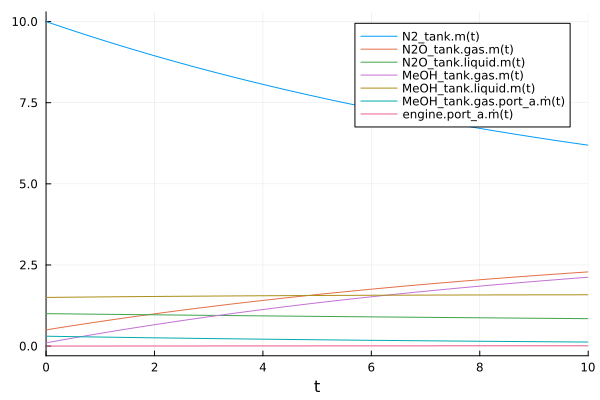

In [63]:
plot(sol)

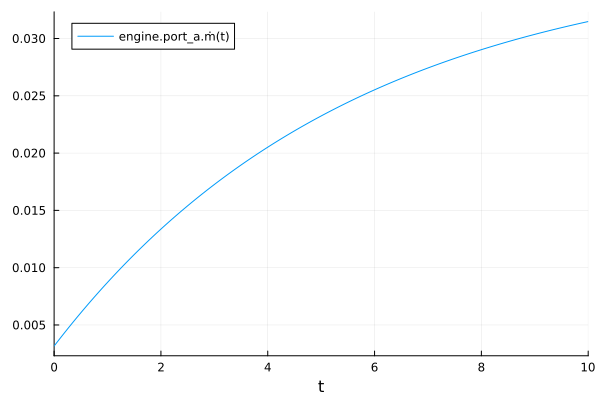

In [52]:
plot(sol, idxs = [engine.port_a.ṁ])

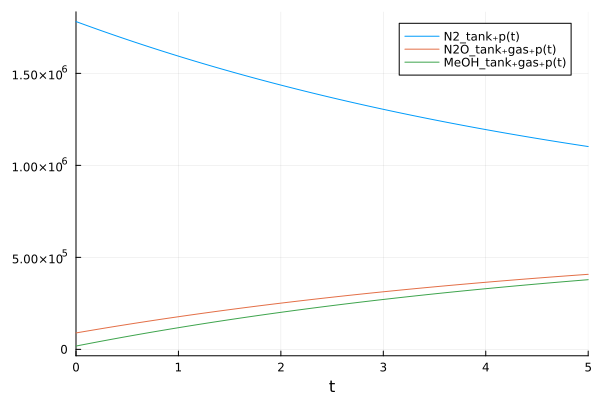

In [30]:
plot(sol, idxs = [N2_tank.p, N2O_tank.gas.p, MeOH_tank.gas.p])

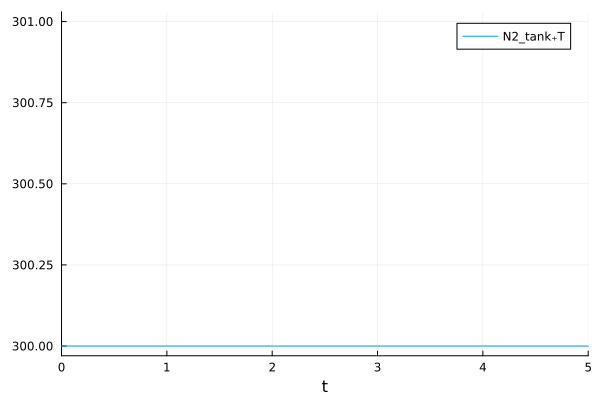

In [32]:
plot(sol, idxs = [N2_tank.T])